# Positive Rating Prediction at stores in Israel

In this project. I'll answer the following question 
whether it is possible or not to predict a Positive rating of a store in Israel
in accordance with many factors that we'll see soon

# Importing packages

This lines of codes are responsible for installing and importing the necessary libraries

In [3]:
from bs4 import BeautifulSoup
import pandas as pd
import numpy as np
import scipy as sc
import requests
import re
import seaborn as sns
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import sklearn
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn import linear_model
from sklearn.decomposition import PCA

# Data Acquisition

First we need to gather relevant information and data in order to build our DataFrame.
The method I shall be using is "Crawling" from the website https://www.zap.co.il .
The website provides a great amount of reviews for a huge amount of stores in Israel.
We will fetch from the website by inspecting the source code of the pages


In [3]:
# URLS of the store pages that will be used
url1="https://www.zap.co.il/modelsstore.aspx?sog=g-stores&orderby=rate"
url2="https://www.zap.co.il" 
url5="https://www.zap.co.il/modelsstore.aspx?sog=g-stores&pageinfo=31&gclid=cj0kcqiaq5mebhcyarisajrtdr5fdiroscocnkwwobzmeamb6knu_mjhvbs9xdsdly0te4xmvviupacaall5ealw_wcb"

In [ ]:
#Function that loads a BeautifulSoup obj for a certain url to work with.
def load_soup_object(lnk):
    user_agent = {'User-agent': 'Mozilla/5.0'}
    response1 = requests.get(lnk,headers=user_agent)
    soup1 = BeautifulSoup(response1.content, "html.parser")
    return soup1

In [ ]:
#Lists that define the columns of the DataFrame that'll I build
Store_Name = [] #Store name
AverageStore_Rating = [] # The Score average Rating of a store
Positive_Rating = [] # Amount of people that gave the store a positive review
Negative_Rating = [] # Amount of people that gave the store a negative review
Comments_Count = []  # Amount of comments on the store Page 
LastM_Rating=[]      # Amount of people that gave the store a positive review in the last month
Last3M_Rating = []   # Amount of people that gave the store a positive review in the Three months
Last6M_Rating = []   # Amount of people that gave the store a positive review in the Six Months
LastYear_Rating = [] # Amount of people that gave the store a positive review in the last year
YearsLong=[]         # How "old" is the store/how long the store has been serving for 

In [ ]:
# A function that fixes the score that has been fetched from the source code.
# receives an array of the number and transforms it into a Real number
# for example [4,34] transforms it into 4.34 
def fixNum(score):
    if(score[1]=="00"):
        score[1]="0"
    f1=float(score[0])
    f2=float(score[1])
    f3=f1+(f2/100)
    return f3

In [ ]:
# This function Gets an array of strings and concates them into the name of the store
def fixName(name):
    str=""
    for i in range(len(name)):
        str+=name[i]+" "
    return str

In [ ]:
#This function iterates over every single store link
#in the current page by the url that it just received and returns a list of links to the store pages
def NextLinkInner(urlOuter): 
    soup=load_soup_object(urlOuter)
    urlList=[]
    searches = soup.find(class_="StoreBoxes").find_all('a') #extracting the corresponding link with the href tag
    counter=0
    for link in searches:
        if(counter>=len(searches)):
            break
        try:
            href = searches[counter].get("href").strip()
            url3=url2+href #concatanating it to the original URL
            if r'https://www.zap.co.il/clientcard.aspx?siteid' in url3: #if the default prefix exists in the url
                urlList.append(url3)
        except:
            print("Wrong link or Couldn't access a certain link")
        counter+=1
    urlList=list(dict.fromkeys(urlList))
    return urlList

In [ ]:
#This function will iterate all pages and get link to the next page everytime. it receives counter2 
#counter2 functions as the number of the current page and the soup obj to work with
def NextLinkOuter(counter2,soup):
    if(counter2==1):
        return "https://www.zap.co.il/modelsstore.aspx?sog=g-stores&orderby=rate" #if its the first link it'll
                                                                                  #return this link by default
    nextLink=""
    searches = soup.find(class_="PageNumbers").find_all('a') #extracting the corresponding link with the href tag
    counter=0                                                
    for link in searches: #we go through all the links in the searches and check if it contains the page number we look for
        if(counter>=len(searches)): #if we went through all the links then break
            break
        try:
            href = searches[counter].get("href").strip()
            urlOut1=url2+href #concatanating it to the original URL
            str1=f'pageinfo={counter2}' 
            if str1 in urlOut1:
                nextLink=urlOut1
        except:
            print("Couldn't access a certain link")
        counter+=1
        #since the next links are encoded and we cannot simply access them we'll just simply concatanate the next page number
        if(counter2>=10):
            nextLink="https://www.zap.co.il/modelsstore.aspx?sog=g-stores&orderby=rate&pageinfo="+str(counter2)
    soup=nextLink
    return nextLink

In [ ]:
counter2=1
soup=load_soup_object("https://www.zap.co.il/modelsstore.aspx?sog=g-stores&orderby=rate")
for i in range(393):
    urlNew=NextLinkOuter(counter2,soup)
    counter2+=1
    urlList1=NextLinkInner(urlNew)
    # urlList1 is a list with all the links we want to iterate through and extract only the ones we want
    # I'm getting every link from the link  list, and check if i can load it into a soup obj
    # if the soup is loaded, we are iterating now on the page of that link and we'll fetch all the desired data
    # else it'll throw and exception 
    for url in urlList1:
        try:
            soup1=load_soup_object(url)
        except:
            print("cannot access for some reason")
        lister=soup1.find_all('div',attrs={'class':'MainDiv'})
        for result in lister:
        # here,I'm accessing the class that contains the object we need
            try:
            #Average Scores fetch
                score= result.find('div',attrs={'class','score'}).get_text()
                score=re.findall(r'\d+',score)
                if len(score)==0: #if score is empty 
                    AverageStore_Rating.append(None)
                else:
                    numFix=fixNum(score) 
                    AverageStore_Rating.append(numFix)
            except:
                AverageStore_Rating.append(None)
            try:
            #Store Names fetch
                name= result.find('span',attrs={'class','StoreName'}).get_text()
                pattern = "\w+"
                name=re.findall(pattern,name)
                fixedStr=fixName(name)
                if(fixedStr==""): #if its still empty after the fix
                    fixedStr=None
                Store_Name.append(fixedStr)
            except:
                Store_Name.append(None)
            try:
                #comments count fetch
                commentCount= result.find('span',attrs={'class','number'}).get_text()
                commentCount=re.findall(r'\d+',commentCount)
                Comments_Count.append(commentCount[0])
            except:
                Comments_Count.append(None)
            try:
                # Ages of the stores Fetch
                Year=[]
                #Since there's multiple classes with the same class name
                #we'll iterate through all of them and get the name we desire
                for item in result.findAll('div', {'class': 'InfoTitle'}):
                    Year.append(item.text)                                 
                YearCount=re.findall(r'\d+',Year[2]) #The year is placed at the array at index 2
                currentYear=int(YearCount[0])
                #we'll want to see how old the store is so
                #we'll take our current year minus the year of the store that was put on the website
                YearsLong.append(2023-currentYear)   
            except:
                YearsLong.append(None)
            try:
                #Negative_Rating fetch
                NegativeTotal=[]
                #again,Since there's multiple classes with the same class name
                #we'll iterate through all of them and get the name we desire
                for item in result.findAll('div', {'class': 'TimesNegative'}):       
                    NegativeTotal.append(item.text)
                #The negative Count is placed at the array negativeTotal at index 4
                negativeCount=re.findall(r'\d+',NegativeTotal[4])
                Negative_Rating.append(negativeCount[0])
            except:
                Negative_Rating.append(None)
            try:
                Avg_Per_mnth=[]
                #again,Since there's multiple classes with the same class name
                #we'll iterate through all of them and get the name we desire
                for item in result.findAll('div', {'class': 'TimesPositive InvertedColorsImg'}):       
                    Avg_Per_mnth.append(item.text)
                #The Last month Count is placed at the array Avg_Per_mnth at index 0
                #The Last three month Count is placed at the array Avg_Per_mnth at index 1
                #The Last six month Count is placed at the array Avg_Per_mnth at index 2
                #The Last Year Count is placed at the array Avg_Per_mnth at index 3
                #The Total Positive Count is placed at the array Avg_Per_mnth at index 4
                last_mnth=re.findall(r'\d+',Avg_Per_mnth[0])
                three_mnth=re.findall(r'\d+',Avg_Per_mnth[1])
                six_mnth=re.findall(r'\d+',Avg_Per_mnth[2])
                last_year=re.findall(r'\d+',Avg_Per_mnth[3])
                Total_Positive=re.findall(r'\d+',Avg_Per_mnth[4])
                LastM_Rating.append(last_mnth[0])
                Last3M_Rating.append(three_mnth[0])           
                Last6M_Rating.append(six_mnth[0])
                LastYear_Rating.append(last_year[0])
                Positive_Rating.append(Total_Positive[0]) 
            except:
                LastM_Rating.append(None)
                Last3M_Rating.append(None)           
                Last6M_Rating.append(None)
                LastYear_Rating.append(None)

In [ ]:
#creating the dataframe:
data={'Store Name':Store_Name,'Age':YearsLong,'Comments Count':Comments_Count,"average rate":AverageStore_Rating,
      "Positive Rating":Positive_Rating,"Negative Rating":Negative_Rating,
     "Last month":LastM_Rating,"Last3Month":Last3M_Rating,"Last6Month":Last6M_Rating,"Last Year":LastYear_Rating}
df = pd.DataFrame.from_dict(data, orient='index')
df = df.transpose()
df.to_csv('Table.csv')

In order to make things more efficient, I saved the csv to my computer and from now on will work it

# Data cleaning
By looking at our dataframe, we can see that it contains 10 columns:
9 of the columns are store parameters that are float.
1 column stands for the name of the store which is an object type

In [3]:
df=pd.read_csv('Table.csv',index_col=[0])
df.describe()
df.head()

,Store Name,Age,Comments Count,average rate,Positive Rating,Negative Rating,Last month,Last3Month,Last6Month,Last Year
0,רשת MDK,20.0,1591.0,5.0,1332.0,237.0,3.0,7.0,8.0,18.0
1,ביימקס BuyMax,6.0,896.0,5.0,894.0,1.0,10.0,21.0,47.0,113.0
2,רוק פתרונות טכניים,9.0,803.0,5.0,791.0,5.0,2.0,10.0,22.0,54.0
3,בטר שופ,7.0,779.0,5.0,778.0,1.0,9.0,32.0,50.0,105.0
4,אל סי דיל,15.0,705.0,5.0,660.0,43.0,0.0,2.0,8.0,32.0


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5502 entries, 0 to 5501
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Store Name       2845 non-null   object 
 1   Age              4508 non-null   float64
 2   Comments Count   5501 non-null   float64
 3   average rate     679 non-null    float64
 4   Positive Rating  2645 non-null   float64
 5   Negative Rating  2645 non-null   float64
 6   Last month       2645 non-null   float64
 7   Last3Month       2645 non-null   float64
 8   Last6Month       2645 non-null   float64
 9   Last Year        2645 non-null   float64
dtypes: float64(9), object(1)
memory usage: 472.8+ KB


# Looking into our DataFrame

Firstly, I dropped all the rows that have missing values that contain NAN as well as the average rate column that more than 75% out of it has been proved to be NAN. replacing those values with mean or median values might bring false results.
Secondly,I dropped all the duplicated rows that contain the same store name.
Lastly, With our dataFrame, I used visualizations that show and detect outliers and most importantly relations between the parameters

In [5]:
#dropping the rows that contain NAN
df_clean =df[df['Store Name'].notna()]
df_clean =df_clean[df_clean['Positive Rating'].notna()]
df_clean =df_clean[df_clean['Negative Rating'].notna()]
df_clean =df_clean[df_clean['Comments Count'].notna()]
df_clean =df_clean[df_clean['Last month'].notna()]
df_clean =df_clean[df_clean['Last3Month'].notna()]
df_clean =df_clean[df_clean['Last6Month'].notna()]
df_clean =df_clean[df_clean['Last Year'].notna()]
#dropping the average rate column
df_clean.drop('average rate', inplace=True, axis=1)
df_clean =df_clean[df_clean['Age'].notna()]
#dropping the duplicate store names columns
df_clean=df_clean.drop_duplicates(subset=['Store Name'])
df_clean.reset_index(drop=True)
df_clean.info()
df2=df_clean.copy()
df2

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2272 entries, 0 to 2644
Data columns (total 9 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Store Name       2272 non-null   object 
 1   Age              2272 non-null   float64
 2   Comments Count   2272 non-null   float64
 3   Positive Rating  2272 non-null   float64
 4   Negative Rating  2272 non-null   float64
 5   Last month       2272 non-null   float64
 6   Last3Month       2272 non-null   float64
 7   Last6Month       2272 non-null   float64
 8   Last Year        2272 non-null   float64
dtypes: float64(8), object(1)
memory usage: 177.5+ KB


,Store Name,Age,Comments Count,Positive Rating,Negative Rating,Last month,Last3Month,Last6Month,Last Year
0,רשת MDK,20.0,1591.0,1332.0,237.0,3.0,7.0,8.0,18.0
1,ביימקס BuyMax,6.0,896.0,894.0,1.0,10.0,21.0,47.0,113.0
2,רוק פתרונות טכניים,9.0,803.0,791.0,5.0,2.0,10.0,22.0,54.0
3,בטר שופ,7.0,779.0,778.0,1.0,9.0,32.0,50.0,105.0
4,אל סי דיל,15.0,705.0,660.0,43.0,0.0,2.0,8.0,32.0
...,...,...,...,...,...,...,...,...,...
2640,פייבר פי סי,12.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0
2641,לקטבע,13.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0
2642,lunch kit,13.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0
2643,לנ טק,13.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0


In [6]:
df2.describe(include='all')

,Store Name,Age,Comments Count,Positive Rating,Negative Rating,Last month,Last3Month,Last6Month,Last Year
count,2272,2272.000000,2272.000000,2272.000000,2272.000000,2272.000000,2272.000000,2272.000000,2272.000000
unique,2272,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,רשת MDK,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,NaN,11.098151,100.443222,74.740317,11.968750,0.520687,1.897447,3.578785,7.507923
std,NaN,4.984128,311.575141,267.338310,48.006746,2.660359,9.245969,16.648355,32.077610
min,NaN,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,NaN,7.000000,3.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,NaN,11.000000,12.000000,6.000000,2.000000,0.000000,0.000000,0.000000,0.000000
75%,NaN,15.000000,67.000000,33.000000,6.250000,0.000000,0.000000,0.000000,1.000000


# outliers cleaning-EDA

Now lets check the outliers by doing some EDA

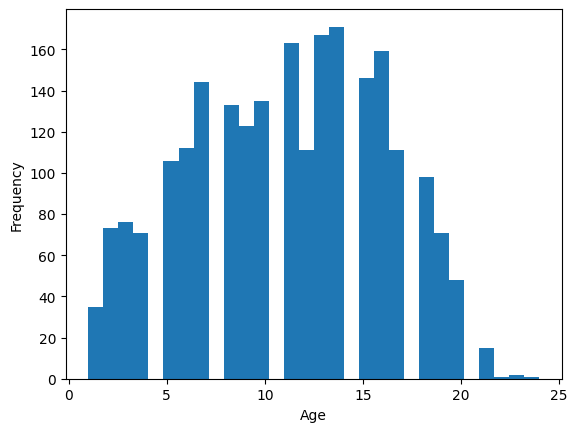

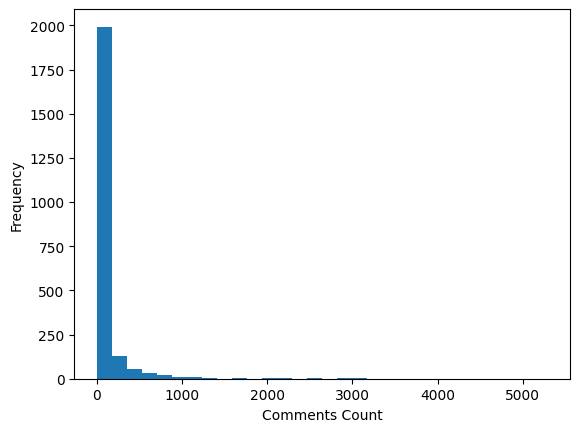

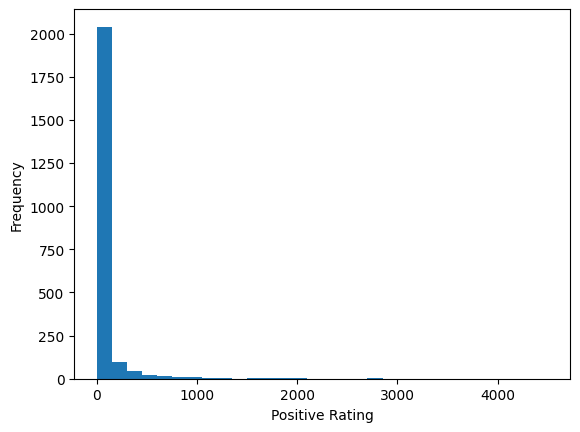

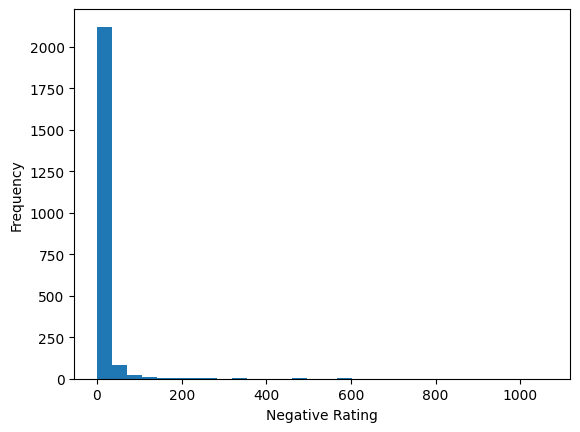

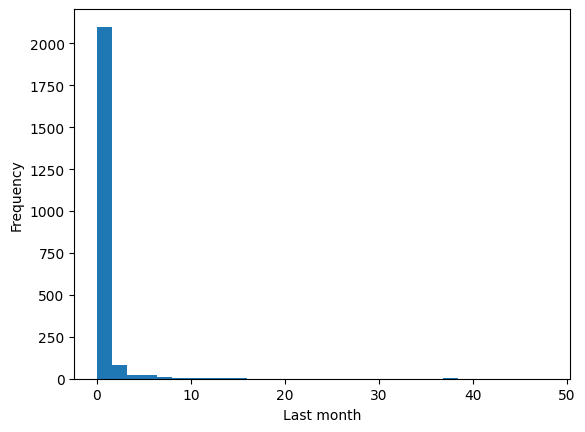

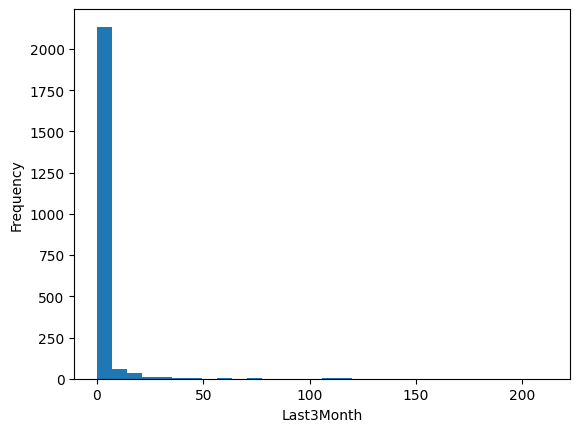

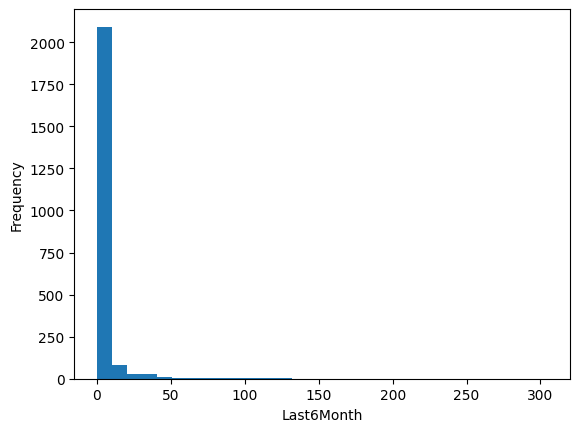

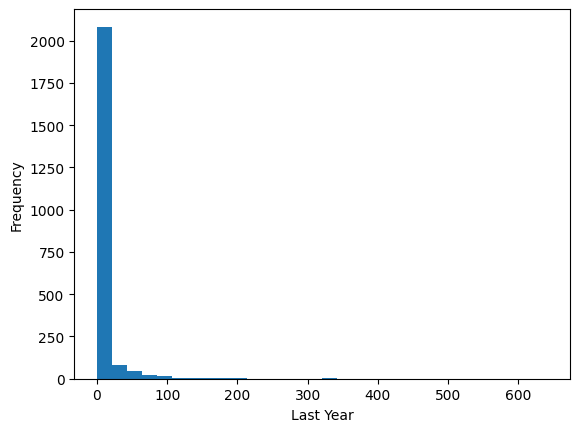

In [7]:
#this function receives a dataframe and displays histogram per every column that is being iterated in the loop
def display_histograms(df):
    columns = df.select_dtypes(['float64']).columns #all the columns except of the name of the store column
    for col in columns:
        plt.hist(df[col], bins=30)
        plt.xlabel(str(col))
        plt.ylabel("Frequency")
        plt.show()
display_histograms(df2)

Here we can notice that most of those Histograms(except of the Age) have a long tail- There we can define those values as outliers

In [8]:
df2[df2["Comments Count"]>1600]=np.nan
df2[df2["Positive Rating"]>1500]=np.nan
df2[df2["Negative Rating"]>300]=np.nan
df2[df2["Last month"]>20]=np.nan
df2[df2["Last3Month"]>125]=np.nan
df2[df2["Last6Month"]>90]=np.nan
df2[df2["Last Year"]>150]=np.nan

In [9]:
#pd.set_option('display.max_rows', None)
pd.reset_option('display.max_rows')
df2_clean=df2.copy()

In [10]:
df2_clean

,Store Name,Age,Comments Count,Positive Rating,Negative Rating,Last month,Last3Month,Last6Month,Last Year
0,רשת MDK,20.0,1591.0,1332.0,237.0,3.0,7.0,8.0,18.0
1,ביימקס BuyMax,6.0,896.0,894.0,1.0,10.0,21.0,47.0,113.0
2,רוק פתרונות טכניים,9.0,803.0,791.0,5.0,2.0,10.0,22.0,54.0
3,בטר שופ,7.0,779.0,778.0,1.0,9.0,32.0,50.0,105.0
4,אל סי דיל,15.0,705.0,660.0,43.0,0.0,2.0,8.0,32.0
...,...,...,...,...,...,...,...,...,...
2640,פייבר פי סי,12.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0
2641,לקטבע,13.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0
2642,lunch kit,13.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0
2643,לנ טק,13.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0


In [11]:
#dropping the rows that contain NAN
df2_clean =df2_clean[df2_clean['Store Name'].notna()]
df2_clean =df_clean[df_clean['Positive Rating'].notna()]
df2_clean =df_clean[df_clean['Negative Rating'].notna()]
df2_clean =df_clean[df_clean['Comments Count'].notna()]
df2_clean =df_clean[df_clean['Last month'].notna()]
df2_clean =df_clean[df_clean['Last3Month'].notna()]
df2_clean =df_clean[df_clean['Last6Month'].notna()]
df2_clean =df_clean[df_clean['Last Year'].notna()]
df2_clean =df2_clean.reset_index(drop=True)

Now lets save the dataframe after the cleanup and look at the stats based on the cleaning we've done

In [12]:
DfNew=df2_clean.copy()
DfNew.info()
DfNew.describe()
DfNew
DfNew.to_csv('TableCleaned.csv')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2272 entries, 0 to 2271
Data columns (total 9 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Store Name       2272 non-null   object 
 1   Age              2272 non-null   float64
 2   Comments Count   2272 non-null   float64
 3   Positive Rating  2272 non-null   float64
 4   Negative Rating  2272 non-null   float64
 5   Last month       2272 non-null   float64
 6   Last3Month       2272 non-null   float64
 7   Last6Month       2272 non-null   float64
 8   Last Year        2272 non-null   float64
dtypes: float64(8), object(1)
memory usage: 159.9+ KB


# Data Visualizations
Now I'll show the relations between the parameters and we'll see how it'll help as well with the future prediction model

In [36]:
df=pd.read_csv('TableCleaned.csv',index_col=[0])
df.describe()
df

,Store Name,Age,Comments Count,Positive Rating,Negative Rating,Last month,Last3Month,Last6Month,Last Year
0,רשת MDK,20.0,1591.0,1332.0,237.0,3.0,7.0,8.0,18.0
1,ביימקס BuyMax,6.0,896.0,894.0,1.0,10.0,21.0,47.0,113.0
2,רוק פתרונות טכניים,9.0,803.0,791.0,5.0,2.0,10.0,22.0,54.0
3,בטר שופ,7.0,779.0,778.0,1.0,9.0,32.0,50.0,105.0
4,אל סי דיל,15.0,705.0,660.0,43.0,0.0,2.0,8.0,32.0
...,...,...,...,...,...,...,...,...,...
2267,פייבר פי סי,12.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0
2268,לקטבע,13.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0
2269,lunch kit,13.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0
2270,לנ טק,13.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0


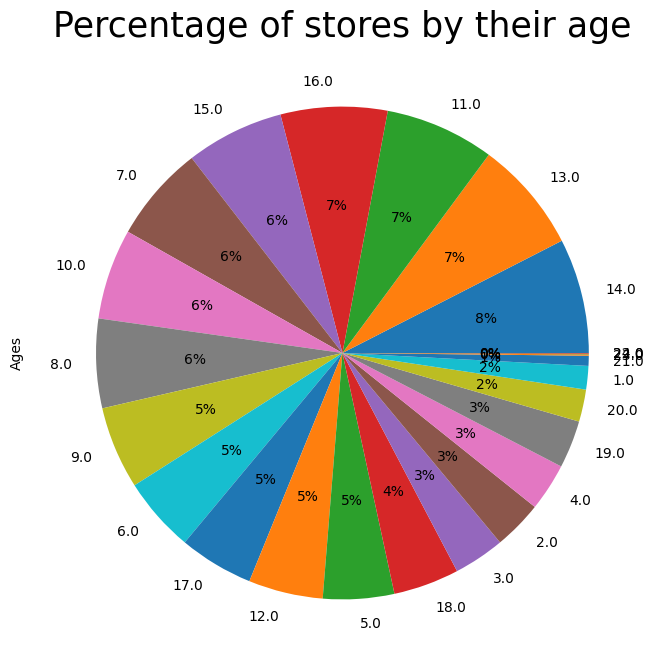

In [37]:
fig, ax = plt.subplots(figsize=(8, 8))
ax.set_title('Percentage of stores by their age', fontsize=25)
ax = df['Age'].sort_index().value_counts(normalize=True).plot.pie(autopct='%1.0f%%')
ax.set_ylabel("Ages")
plt.show()

On kernel density plots, kernel smoothing is used.
Here I made a kernel density plot for the variable Positive Rating,Age and Comments Count

<AxesSubplot: xlabel='Positive Rating', ylabel='Density'>

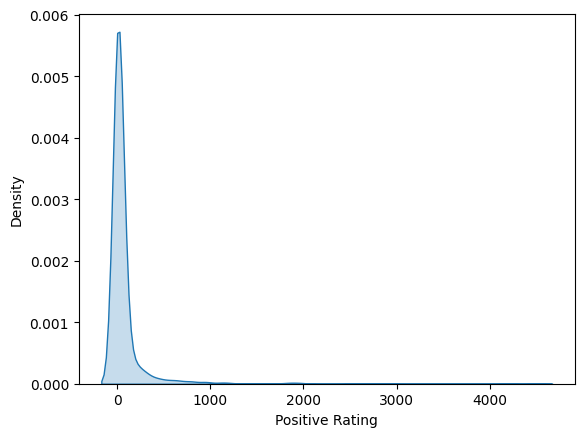

In [38]:
sns.kdeplot(df['Positive Rating'], fill=True)

<AxesSubplot: xlabel='Age', ylabel='Density'>

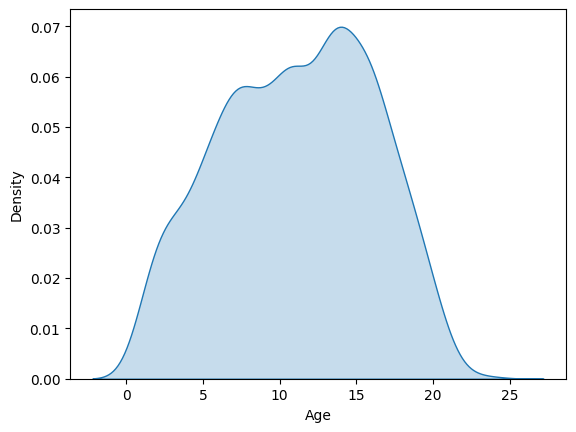

In [39]:
sns.kdeplot(df['Age'], fill=True)

Here we can make 2 of those plots on the same graph enabling us to compare ditributions

<AxesSubplot: xlabel='Positive Rating', ylabel='Density'>

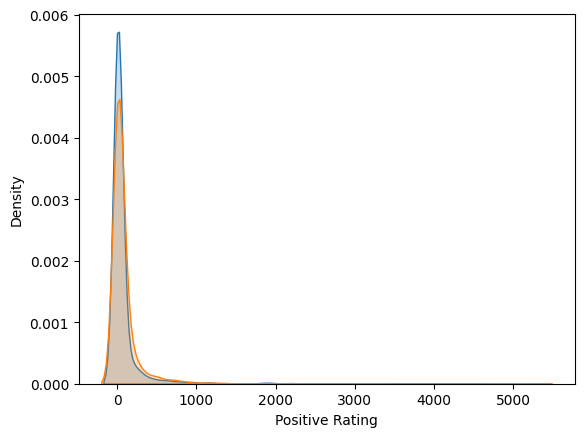

In [40]:
ax = sns.kdeplot(df['Positive Rating'], fill=True)
sns.kdeplot(df['Comments Count'], fill=True)

Here we can see the use of the scatter3D.
we can see the relation between parameters. but visualizing in 3D could be a little challenging and difficult, That's why we'll move now to pairplots

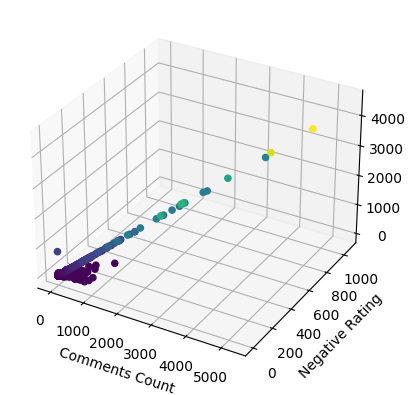

In [41]:
ax=plt.axes(projection='3d')
xdata=df['Comments Count']
zdata=df['Positive Rating']
ydata=df['Negative Rating']
plt.xlabel('Comments Count')
plt.ylabel('Negative Rating')
ax.scatter3D(xdata,ydata,zdata,c=zdata,depthshade=False)

Here we got a matrix of Scatter Plots according to the parameters that we just put in the function.
This is a quick and an effective way to check a relation between this variables


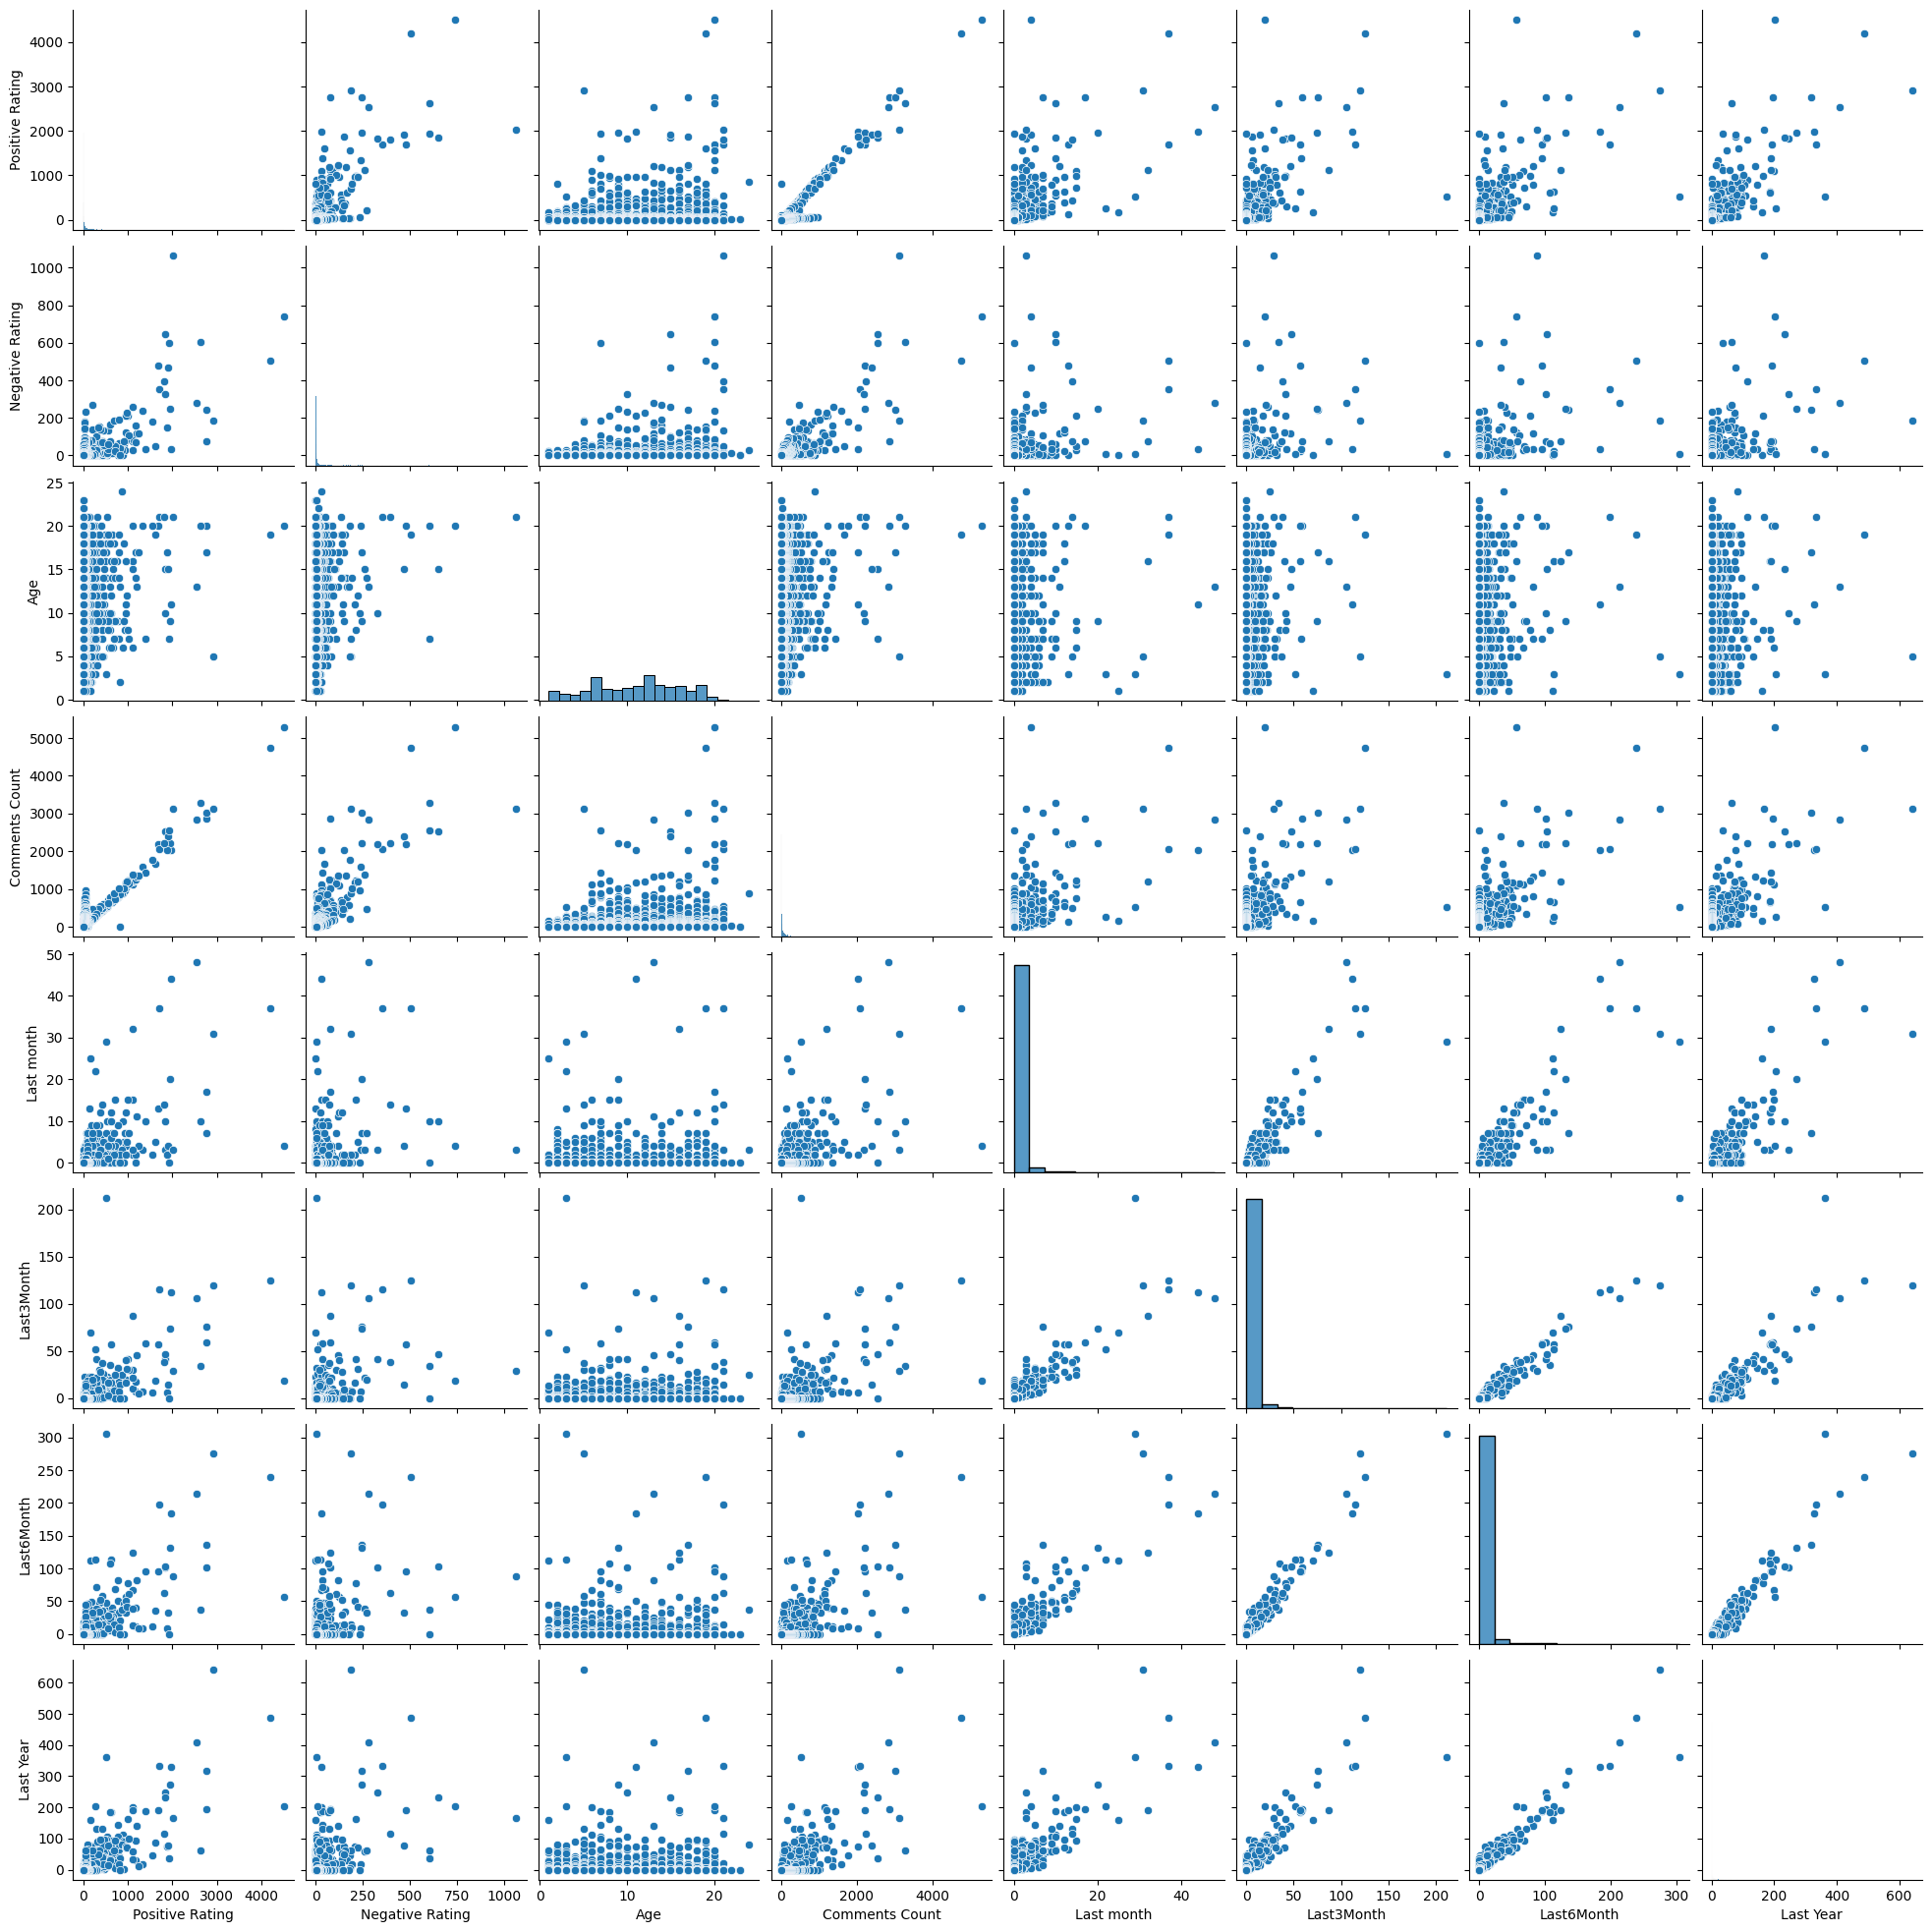

In [42]:
sns.pairplot(df[['Positive Rating','Negative Rating','Age','Comments Count','Last month','Last3Month','Last6Month','Last Year']])

We can see that some of the relations are linear.
For example we can see it go for between the Positive Rating and The amount of comments.
To make stuff more easier, Let's visualize this correlations with the heatmap.
This visualization technique allows us to present third multiple dimensional data.
Heatmaps show us values as a function of two dimensions.

<AxesSubplot: >

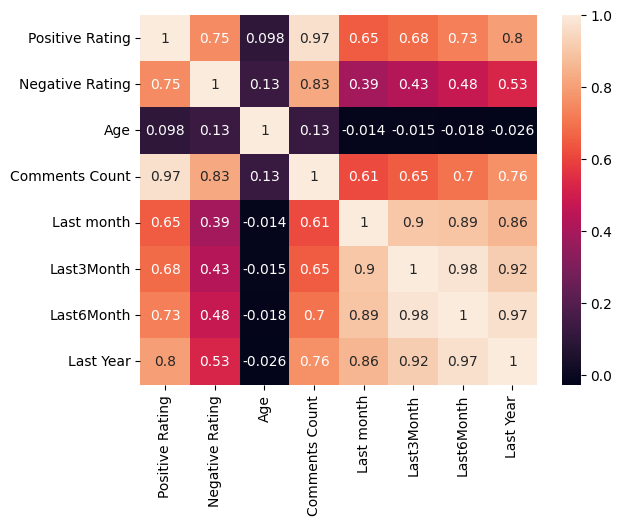

In [43]:
heatmap2 = pd.DataFrame(df, columns = ['Positive Rating','Negative Rating','Age','Comments Count','Last month',
                                       'Last3Month','Last6Month','Last Year'])
sns.heatmap(heatmap2.corr(), annot=True)

Lets focus now at each parameter compared to our Positive Rating

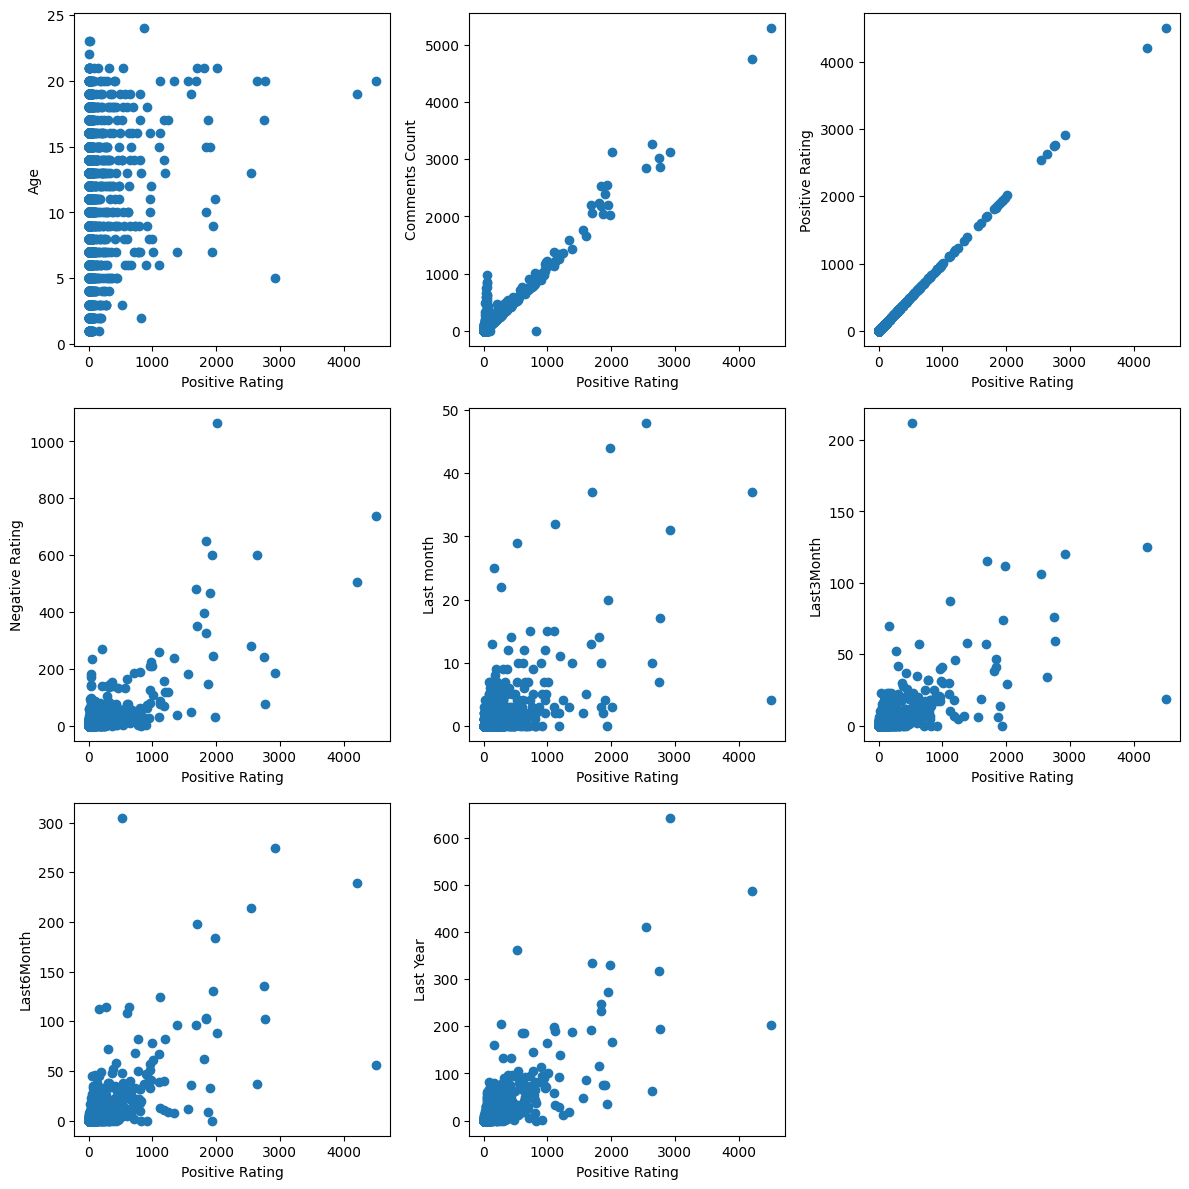

In [44]:
for i in range(1,9):
    col = df.columns[i]
    plt.subplot(3, 3, i)
    plt.scatter(df["Positive Rating"], df[col])
    plt.xlabel("Positive Rating",fontsize = 10)
    plt.ylabel(df.columns[i],fontsize = 10)
    plt.gcf().set_size_inches((12, 12)) 
plt.tight_layout()

In [45]:
df[['Positive Rating','Negative Rating','Comments Count','Age','Last month','Last3Month','Last6Month','Last Year']].corr()

,Positive Rating,Negative Rating,Comments Count,Age,Last month,Last3Month,Last6Month,Last Year
Positive Rating,1.000000,0.751728,0.971707,0.098325,0.650945,0.682136,0.725943,0.795932
Negative Rating,0.751728,1.000000,0.826043,0.132710,0.387762,0.431617,0.477085,0.526277
Comments Count,0.971707,0.826043,1.000000,0.126408,0.614788,0.650961,0.695859,0.763694
Age,0.098325,0.132710,0.126408,1.000000,-0.014250,-0.015003,-0.017990,-0.025997
Last month,0.650945,0.387762,0.614788,-0.014250,1.000000,0.903621,0.894748,0.859556
Last3Month,0.682136,0.431617,0.650961,-0.015003,0.903621,1.000000,0.976381,0.917734
Last6Month,0.725943,0.477085,0.695859,-0.017990,0.894748,0.976381,1.000000,0.968003
Last Year,0.795932,0.526277,0.763694,-0.025997,0.859556,0.917734,0.968003,1.000000


for example, Again from here We can see from the second graph the more comments there are, The higher gets the positive rating.
This EDAs will help us build a prediction model later on

Now lets take this specific graph and take a closer look at it by adding another element, age.

<AxesSubplot: xlabel='Comments Count', ylabel='Positive Rating'>

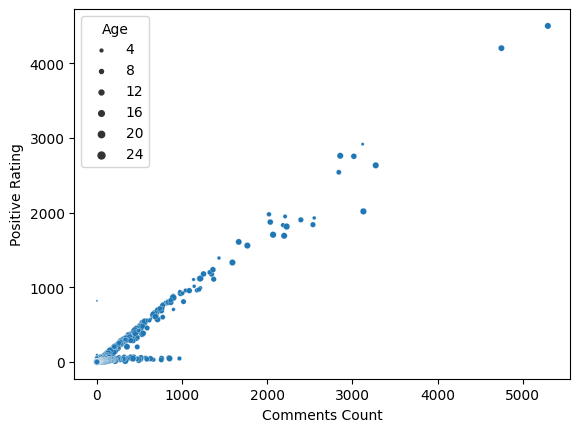

In [46]:
sns.scatterplot(x='Comments Count',y='Positive Rating',s=7,data=df,size="Age",sizes=(1,25))

# Machine Learning
Lets start using the Machine Learning algorithm

# Linear Regression
The method I have chosen is Linear Regression since the problem I'm facing is a regression problem. I wanted to predict the exact value and check how precisely I can predict it. The target column that I'll want to predict is the Positive Rating Column. 

In [52]:
df_learn=df[['Positive Rating','Negative Rating','Age','Comments Count','Last month','Last3Month','Last6Month','Last Year']]


In [53]:
TRAINING_FEATURES = df_learn.columns[df_learn.columns != 'Positive Rating'] #Here I excluded the column that We wish to predict
TARGET_FEATURE = 'Positive Rating'
x = df_learn[TRAINING_FEATURES] # matrix X of all the variables
y = df_learn[TARGET_FEATURE] # vector y (label) that contains only the Positive Rating

First we'll use The train test method,
which is used to split the data in a way that most values are used to train the model,
and puts a small part of the data to test what the model learned.
test size will be 25% of the data. 75% of the data will be used to train the model.

In [54]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.25)
print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)

(1704, 7) (1704,)
(568, 7) (568,)


Model training and predictions display used on the 75% of the test:

In [55]:
lr = linear_model.LinearRegression()
lr_model = lr.fit(x_train, y_train)
lr_predictions = lr.predict(x_test)
lr_predictions

array([-5.19234055e+00,  9.16644388e+02,  6.77327600e+01, -4.05860974e+00,
        5.32569942e-02,  1.00720164e+02, -5.46668304e+00,  1.93129367e+01,
       -5.04022822e+00,  3.22319287e+00,  8.81466636e+01,  1.90688969e+01,
        2.29983486e+01, -7.57942570e+00,  4.11658356e+01, -3.34219162e+00,
        6.12453241e+02, -8.17047647e+00,  2.65035867e+02, -7.07219507e+00,
        1.67765043e-01,  1.50161569e+02, -6.59045313e+00,  9.71354092e+00,
       -6.27546202e+00,  1.93648389e+02,  1.02229321e+02, -7.96999341e+00,
        1.13795951e+01,  1.73453900e+01, -5.29688788e+00, -9.18493772e+00,
       -6.39516928e+00,  7.38624413e+01,  5.85976311e-01,  1.16364411e+01,
       -3.97263472e+00, -4.11694120e+00,  6.78694638e+01,  3.38092126e+01,
        6.59904737e+01,  4.74512605e-01, -7.18365878e+00, -5.21306773e+00,
        2.42777131e+01,  5.70034178e+01,  7.54074374e+00, -5.53921530e+00,
        3.83633968e+02,  1.28849079e+00,  4.31608246e+02,  4.21560861e+02,
       -3.71077586e+00,  

# Precision of the predictions:

Here we can see that the precision is adverbnearly 0.96 score which is excellent

In [56]:
print("Score: ", lr_model.score(x_test, y_test))

Score:  0.9563448243067838


In [57]:
PredVSActual = pd.DataFrame(x_test)
PredVSActual['Positive Actual Rating'] = y_test
PredVSActual['Positive Predicted Rating'] = lr_predictions
PredVSActual = PredVSActual.reset_index()
x_test = PredVSActual.columns[PredVSActual.columns != 'index']
PredVSActual[x_test]

,Negative Rating,Age,Comments Count,Last month,Last3Month,Last6Month,Last Year,Positive Actual Rating,Positive Predicted Rating
0,2.0,8.0,4.0,0.0,1.0,1.0,1.0,64.0,-5.192341
1,225.0,12.0,1199.0,5.0,31.0,41.0,72.0,971.0,916.644388
2,6.0,15.0,88.0,0.0,0.0,0.0,4.0,60.0,67.732760
3,1.0,14.0,7.0,0.0,0.0,0.0,0.0,4.0,-4.058610
4,2.0,15.0,13.0,0.0,0.0,0.0,0.0,0.0,0.053257
...,...,...,...,...,...,...,...,...,...
563,0.0,17.0,4.0,0.0,0.0,0.0,0.0,3.0,-6.650939
564,0.0,15.0,38.0,0.0,0.0,0.0,0.0,14.0,22.574938
565,0.0,17.0,4.0,0.0,0.0,0.0,0.0,3.0,-6.650939
566,1.0,13.0,1.0,0.0,0.0,0.0,0.0,1.0,-8.872991


In [58]:
condition  = (PredVSActual['Positive Predicted Rating'] <0 )
PredVSActual.loc[condition, 'Positive Predicted Rating'] = 0
PredVSActual[x_test]

,Negative Rating,Age,Comments Count,Last month,Last3Month,Last6Month,Last Year,Positive Actual Rating,Positive Predicted Rating
0,2.0,8.0,4.0,0.0,1.0,1.0,1.0,64.0,0.000000
1,225.0,12.0,1199.0,5.0,31.0,41.0,72.0,971.0,916.644388
2,6.0,15.0,88.0,0.0,0.0,0.0,4.0,60.0,67.732760
3,1.0,14.0,7.0,0.0,0.0,0.0,0.0,4.0,0.000000
4,2.0,15.0,13.0,0.0,0.0,0.0,0.0,0.0,0.053257
...,...,...,...,...,...,...,...,...,...
563,0.0,17.0,4.0,0.0,0.0,0.0,0.0,3.0,0.000000
564,0.0,15.0,38.0,0.0,0.0,0.0,0.0,14.0,22.574938
565,0.0,17.0,4.0,0.0,0.0,0.0,0.0,3.0,0.000000
566,1.0,13.0,1.0,0.0,0.0,0.0,0.0,1.0,0.000000
